### Neural Networks

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn import linear_model

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### With Feature Engineering

Feature engineering using the following [link](https://www.kaggle.com/code/devassaxd/student-performance-prediction-complete-analysis)

In [35]:
studInfo=pd.read_csv("data/studentInfo.csv")
assessments=pd.read_csv("data/assessments.csv")
studAss=pd.read_csv("data/studentAssessment.csv")
studVle=pd.read_csv("data/studentVle.csv")
vle=pd.read_csv("data/vle.csv")

#### Assessments
The performance in each assessement is a good indicator of the students' knowledge of the course and, as it composes the grade for the final evaluation, it's interesting to make it a feature in the final model. But, as there are many different courses, each with a different structure, it's unfeasible to create a feature for each assessment. In order to include the assessments, we will build 2 features: One of them is the final grade given by the score and the weight of each assessment. The other is a pass rate, created on the premise that a student must get at least 40% score on an assessment to pass it, calculating the percentage of assessments the student sucessfully passed. We also will split final exams from the other assessments, given their status and participation in the final evaluation is different from the other assessments.

In [36]:
exams=assessments[assessments["assessment_type"]=="Exam"]
others=assessments[assessments["assessment_type"]!="Exam"]
amounts=others.groupby(["code_module","code_presentation"]).count()["id_assessment"] 
amounts=amounts.reset_index()
amounts.head()

,code_module,code_presentation,id_assessment
0,AAA,2013J,5
1,AAA,2014J,5
2,BBB,2013B,11
3,BBB,2013J,11
4,BBB,2014B,11


In [37]:
#Function to determine whether a student passed a given assessment
def pass_fail(grade):
    if grade>=40:
        return True
    else:
        return False
#Creating the stud_ass dataframe to join infos about the assessment weights and their respective grades
stud_ass=pd.merge(studAss,others,how="inner",on=["id_assessment"])
stud_ass["pass"]=stud_ass["score"].apply(pass_fail)
stud_ass["weighted_grade"]=stud_ass["score"]*stud_ass["weight"]/100

In [38]:
#Final assessment average per student per module
avg_grade=stud_ass.groupby(["id_student","code_module","code_presentation"]).sum()["weighted_grade"].reset_index()
avg_grade.head()

,id_student,code_module,code_presentation,weighted_grade
0,6516,AAA,2014J,63.50
1,8462,DDD,2013J,34.90
2,8462,DDD,2014J,43.00
3,11391,AAA,2013J,82.40
4,23629,BBB,2013B,16.69


In [39]:
#Pass rate per student per module
pass_rate=pd.merge((stud_ass[stud_ass["pass"]==True].groupby(["id_student","code_module","code_presentation"]).count()["pass"]).reset_index(),amounts,how="left",on=["code_module","code_presentation"])
pass_rate["pass_rate"]=pass_rate["pass"]/pass_rate["id_assessment"]
pass_rate.drop(["pass","id_assessment"], axis=1,inplace=True)
pass_rate.head()

,id_student,code_module,code_presentation,pass_rate
0,6516,AAA,2014J,1.000000
1,8462,DDD,2013J,0.500000
2,8462,DDD,2014J,0.666667
3,11391,AAA,2013J,1.000000
4,23629,BBB,2013B,0.363636


In [40]:
#Final exam scores
stud_exams=pd.merge(studAss,exams,how="inner",on=["id_assessment"])
stud_exams["exam_score"]=stud_exams["score"]
stud_exams.drop(["id_assessment","date_submitted","is_banked", "score","assessment_type","date","weight"],axis=1,inplace=True)
stud_exams.head()

,id_student,code_module,code_presentation,exam_score
0,558914,CCC,2014B,32.0
1,559706,CCC,2014B,78.0
2,559770,CCC,2014B,54.0
3,560114,CCC,2014B,64.0
4,560311,CCC,2014B,100.0


#### VLE
The datasets referring to the VLE (Virtual Learning Environment) contain the interaction feed of the students with the content available for reference throughout the duration of the period. From this data we can infer how in touch a student was with their subjects, whether they studied it on a solid basis and how they used the content.

In [41]:
vle

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,NaN,NaN
1,546712,AAA,2013J,oucontent,NaN,NaN
2,546998,AAA,2013J,resource,NaN,NaN
3,546888,AAA,2013J,url,NaN,NaN
4,547035,AAA,2013J,resource,NaN,NaN
...,...,...,...,...,...,...
6359,897063,GGG,2014J,resource,NaN,NaN
6360,897109,GGG,2014J,resource,NaN,NaN
6361,896965,GGG,2014J,oucontent,NaN,NaN
6362,897060,GGG,2014J,resource,NaN,NaN


In [42]:
vle[~vle["week_from"].isna()]
#Only 1121 from the 6364 entries have the reference week for the materials (the week in which they would be used in course.)
#With this in mind, the construction of a metric to track study commitment becomes impractical

,id_site,code_module,code_presentation,activity_type,week_from,week_to
113,546732,AAA,2013J,oucontent,2.0,2.0
198,546719,AAA,2013J,oucontent,1.0,1.0
210,546681,AAA,2013J,oucontent,1.0,1.0
264,877040,AAA,2014J,oucontent,2.0,2.0
323,877045,AAA,2014J,oucontent,1.0,1.0
...,...,...,...,...,...,...
6243,798728,GGG,2014B,resource,1.0,1.0
6266,897051,GGG,2014J,resource,2.0,2.0
6285,897121,GGG,2014J,resource,1.0,1.0
6304,897050,GGG,2014J,resource,1.0,1.0


In [43]:
studVle.head()

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1


In [44]:
#Here we can track the average time after the start of the course the student took to use the materials
#and the average amount of clicks per material
avg_per_site=studVle.groupby(["id_student","id_site","code_module","code_presentation"]).mean().reset_index()
avg_per_site.head()

,id_student,id_site,code_module,code_presentation,date,sum_click
0,6516,877011,AAA,2014J,210.333333,3.833333
1,6516,877012,AAA,2014J,90.833333,2.310606
2,6516,877015,AAA,2014J,113.461538,2.000000
3,6516,877023,AAA,2014J,122.666667,2.000000
4,6516,877025,AAA,2014J,41.142857,4.333333


In [45]:
#General average per student per module
avg_per_student=avg_per_site.groupby(["id_student","code_module","code_presentation"]).mean()[["date","sum_click"]].reset_index()
avg_per_student.head()

,id_student,code_module,code_presentation,date,sum_click
0,6516,AAA,2014J,105.292573,5.816135
1,8462,DDD,2013J,38.794704,1.734524
2,8462,DDD,2014J,10.000000,3.000000
3,11391,AAA,2013J,111.739069,4.231515
4,23629,BBB,2013B,33.409632,2.817316


#### StudentInfo

The studentInfo table contains various info about the students, but the relevant ones for this analysis are:

- The amount of times the student has already tried to finish the module
- The students' final result

The last one is our interest variable as we build our prediction model

In [46]:
#Removing the cases where the student has withdrawn their registration to the module
studInfo=studInfo[studInfo["final_result"]!="Withdrawn"]
studInfo=studInfo[["code_module","code_presentation","id_student","num_of_prev_attempts","final_result"]]
studInfo.head()

,code_module,code_presentation,id_student,num_of_prev_attempts,final_result
0,AAA,2013J,11391,0,Pass
1,AAA,2013J,28400,0,Pass
3,AAA,2013J,31604,0,Pass
4,AAA,2013J,32885,0,Pass
5,AAA,2013J,38053,0,Pass


#### Compiling all relevant tables

In [47]:
df_1=pd.merge(avg_grade,pass_rate,how="inner",on=["id_student","code_module","code_presentation"])
assessment_info=pd.merge(df_1, stud_exams, how="inner", on=["id_student","code_module","code_presentation"])
assessment_info.head()

,id_student,code_module,code_presentation,weighted_grade,pass_rate,exam_score
0,23698,CCC,2014J,69.97,1.000000,80.0
1,24213,DDD,2014B,78.40,1.000000,58.0
2,27116,CCC,2014J,92.02,1.000000,96.0
3,28046,DDD,2013J,49.90,0.833333,40.0
4,28787,CCC,2014J,11.98,0.375000,44.0


In [48]:
df_2=pd.merge(studInfo,assessment_info,how="inner",on=["id_student","code_module","code_presentation"])
final_df=pd.merge(df_2,avg_per_student,how="inner", on=["id_student","code_module","code_presentation"])
final_df.drop(["id_student","code_module","code_presentation"],axis=1,inplace=True)
final_df.head()
#The final dataframe only has information relevant to the problem

,num_of_prev_attempts,final_result,weighted_grade,pass_rate,exam_score,date,sum_click
0,0,Distinction,89.65,1.000,94.0,103.457907,2.706754
1,0,Pass,84.58,1.000,76.0,87.617265,1.539047
2,0,Pass,51.44,0.625,66.0,49.181286,1.562619
3,0,Pass,75.13,1.000,50.0,118.698642,2.189217
4,0,Distinction,93.22,1.000,98.0,75.791987,2.100617


Delete some outliers to have the most uniform dataset possible

In [49]:
final_df=final_df[final_df["sum_click"]<=10]
final_df=final_df[final_df["num_of_prev_attempts"]<=4]
final_df.head()

,num_of_prev_attempts,final_result,weighted_grade,pass_rate,exam_score,date,sum_click
0,0,Distinction,89.65,1.000,94.0,103.457907,2.706754
1,0,Pass,84.58,1.000,76.0,87.617265,1.539047
2,0,Pass,51.44,0.625,66.0,49.181286,1.562619
3,0,Pass,75.13,1.000,50.0,118.698642,2.189217
4,0,Distinction,93.22,1.000,98.0,75.791987,2.100617


In [50]:
X=final_df.drop("final_result", axis=1)
y=final_df["final_result"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [51]:
X1_test=X_test
X1_train=X_train
X2_test=X_test.drop("weighted_grade",axis=1)
X2_train=X_train.drop("weighted_grade",axis=1)
X3_test=X_test.drop("pass_rate",axis=1)
X3_train=X_train.drop("pass_rate",axis=1)

In [106]:
class StudentDataset(Dataset):

    def __init__(self, X, y, percentage = 1):
        self.X = X.values.tolist()
        self.y = y.values.tolist()

        self.X = self.X[:int(len(self.X)*percentage)]
        self.y = self.y[:int(len(self.y)*percentage)]

    def __len__(self):
        return len(self.X)
        

    def __getitem__(self, idx):
        x_sample = torch.tensor(self.X[idx])
        y_sample = self.y[idx]

        if y_sample == "Fail":
            y_sample = 0.0
        else:
            y_sample = 1.0

        return x_sample.double(), y_sample

In [107]:
dataset_train1 = StudentDataset(X1_train, y_train)
dataset_train2 = StudentDataset(X2_train, y_train)
dataset_train3 = StudentDataset(X3_train, y_train)

dataset_test1 = StudentDataset(X1_test, y_test)
dataset_test2 = StudentDataset(X2_test, y_test)
dataset_test3 = StudentDataset(X3_test, y_test)

In [108]:
dataloader_train1 = DataLoader(dataset_train1, batch_size=16,
                        shuffle=True, num_workers=0)
dataloader_train2 = DataLoader(dataset_train2, batch_size=16,
                        shuffle=True, num_workers=0)
dataloader_train3 = DataLoader(dataset_train3, batch_size=16,
                        shuffle=True, num_workers=0)

dataloader_test1 = DataLoader(dataset_test1, batch_size=16,
                        shuffle=True, num_workers=0)
dataloader_test2 = DataLoader(dataset_test2, batch_size=16,
                        shuffle=True, num_workers=0)
dataloader_test3 = DataLoader(dataset_test3, batch_size=16,
                        shuffle=True, num_workers=0)

In [109]:
x, _ = dataset_train1[0]
in_features1 = len(x)

x, _ = dataset_train2[0]
in_features2 = len(x)

x, _ = dataset_train3[0]
in_features3 = len(x)

In [110]:
class StudentPassClassifier(nn.Module):
    def __init__(self, in_features):
        super(StudentPassClassifier, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(in_features, in_features * 2),
            nn.ReLU(),
            nn.Linear(in_features*2, 1),
            nn.Sigmoid()
        )
        self.double()

    def forward(self, x):
        return self.model(x)

In [111]:
def stop(losses, beta = 5E-5):
    if len(losses) < 2: 
        return False
    last_loss = losses[-2]
    actual_loss = losses[-1]

    return abs(actual_loss - last_loss) < beta

def checkpoint(model, epoch, path):
    torch.save(model.state_dict(), os.path.join(path, f"epoch {epoch}.pt"))

In [142]:
def train(epochs, dataloader, model, optimizer, criterion, path_to_save, data_len, losses = list(), accuracies = list(), checkpoint_epoch = 10):
    for epoch in range(epochs):

        running_loss = 0.0
        corrects = 0.0
        for i, data in enumerate(dataloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = torch.flatten(model(inputs))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            outputs = torch.where(outputs > 0.5, 1.0, 0.0)

            corrects += float(torch.sum(outputs == labels))

        if (epoch % checkpoint_epoch) == 0:
            checkpoint(model, epoch, path_to_save)

        accuracy = corrects/data_len
        accuracies.append(accuracy)
        print("EPOCH {} \t LOSS: {:.5f} \t ACCURACY: {:.5f}".format(epoch+1, running_loss/data_len, accuracy) )

        losses.append(running_loss/data_len)

        if stop(losses, beta = 1E-10):
            checkpoint(model, epoch, path_to_save)
            print("[-] TRAINING STOPPED: DIFFERENCE BETWEEN LOSSES WAS TOO LOW")
            return losses, accuracies


    print('[+] TRAINING FINISHED')
    return losses, accuracies

In [147]:
model1 = StudentPassClassifier(in_features1).to(device)
torch.save(model1.state_dict(), "nn_weights_fe/not_trained1.pt")

model2 = StudentPassClassifier(in_features2).to(device)
torch.save(model2.state_dict(), "nn_weights_fe/not_trained2.pt")

model3 = StudentPassClassifier(in_features3).to(device)
torch.save(model3.state_dict(), "nn_weights_fe/not_trained3.pt")

epochs = 200

criterion = nn.MSELoss()

In [ ]:
def map_from_index(i):
    if i == 0:
        return model1, dataloader_train1, len(dataset_train1)
    if i == 1:
        return model2, dataloader_train2, len(dataset_train2)
    if i == 2:
        return model2, dataloader_train2, len(dataset_train2)

all_results = dict()
for i in range(3):

    print(f"EXECUTING NUMBER {i+1}")
    print("========================================================================================")

    model, dataloader_train, data_len = map_from_index(i)
    results = list()

    for lr in [0.1, 0.01, 0.001, 0.0001, 0.00001]:
        print(f"\tEXECUTING OPTIMIZER WITH LEARNING RATE: {lr}")
        print("\t===================================================================================")

        not_trained_state_dict = torch.load(f"nn_weights_fe/not_trained{i+1}.pt") # Done to reset the network
        model.load_state_dict(not_trained_state_dict)

        optimizer = optim.SGD(model.parameters(), lr=lr)
        path = f"nn_weights_fe/model{i+1}/features_engineering[lr = {lr}]/"
        if not os.path.exists(path):
            os.makedirs(path)
        result = train(epochs, dataloader_train, model, optimizer, criterion, path, data_len, losses = [], accuracies= [])
        results.append(result)

        print("\t===================================================================================")
        print("\n\n\n")

    all_results[i] = results

In [145]:
def eval(model, dataloader, data_len):
    model.eval()
    corrects = 0

    for i, data in enumerate(dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward + backward + optimize
        outputs = torch.flatten(model(inputs))

        outputs = torch.where(outputs > 0.5, 1.0, 0.0)

        corrects += float(torch.sum(outputs == labels))

    print("Precision: {:.3f}".format(corrects/data_len))
    return corrects/data_len

In [146]:
print(eval(model1, dataloader_test1, len(dataset_test1)))

Precision: 0.938
0.9383838383838384


### Without feature engineering

In [3]:
X_train = pd.read_csv("sets/X_train.csv")
X_test = pd.read_csv("sets/X_test.csv")
y_train = pd.read_csv("sets/y_train.csv")
y_test = pd.read_csv("sets/y_test.csv")

In [4]:
class StudentDataset(Dataset):

    def __init__(self, X, y, percentage = 1):
        self.X = X.values.tolist()
        self.y = y.values.tolist()

        self.X = self.X[:int(len(self.X)*percentage)]
        self.y = self.y[:int(len(self.y)*percentage)]

    def __len__(self):
        return len(self.X)
        

    def __getitem__(self, idx):
        x_sample = torch.tensor(self.X[idx])
        y_sample = torch.zeros(10)
        if int(self.y[idx][0]/10) == 10: # <- Not the best solution to access multiple indexes in this horrible way, but it works. Since the y are in a pandas dataframe, when we parse them into list we get a list with each value inside another list.
            y_sample[9] = 1
        else:
            y_sample[int(self.y[idx][0]/10)] = 1

        return x_sample, y_sample
        

In [5]:
dataset_train = StudentDataset(X_train, y_train)
dataset_test = StudentDataset(X_test, y_test)

In [6]:
dataloader_train = DataLoader(dataset_train, batch_size=16,
                        shuffle=True, num_workers=0)

dataloader_test = DataLoader(dataset_test, batch_size=16,
                        shuffle=True, num_workers=0)

In [7]:
x, y = dataset_train[0]
in_features = len(x)
out_features = len(y)

In [8]:
class StudentScoreClassifier(nn.Module):
    def __init__(self):
        super(StudentScoreClassifier, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(in_features, in_features * 2),
            nn.ReLU(),
            nn.Linear(in_features*2, out_features),
            nn.Softmax(dim = 1)
        )

    def forward(self, x):
        return self.model(x)

In [9]:
def stop(losses, beta = 5E-5):
    if len(losses) < 2: 
        return False
    last_loss = losses[-2]
    actual_loss = losses[-1]

    return abs(actual_loss - last_loss) < beta

def checkpoint(model, epoch, path):
    torch.save(model.state_dict(), os.path.join(path, f"epoch {epoch}.pt"))


In [10]:
def train(epochs, dataloader, model, optimizer, criterion, path_to_save, losses = list(), accuracies = list(), checkpoint_epoch = 10):
    for epoch in range(epochs):

        running_loss = 0.0
        corrects = 0.0
        for i, data in enumerate(dataloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, preds = torch.max(outputs.data, 1)
            _, correct_labels = torch.max(labels.data ,1)

            corrects += float(torch.sum(preds == correct_labels))

        if (epoch % checkpoint_epoch) == 0:
            checkpoint(model, epoch, path_to_save)

        accuracy = corrects/len(dataset_train)
        accuracies.append(accuracy)
        print("EPOCH {} \t LOSS: {:.5f} \t ACCURACY: {:.5f}".format(epoch+1, running_loss/len(dataset_train), accuracy) )

        losses.append(running_loss/len(dataset_train))

        if stop(losses):
            checkpoint(model, epoch, path_to_save)
            print("[-] TRAINING STOPPED: DIFFERENCE BETWEEN LOSSES WAS TOO LOW")
            return losses, accuracies


    print('[+] TRAINING FINISHED')
    return losses, accuracies

In [14]:
model = StudentScoreClassifier().to(device)
torch.save(model.state_dict(), "nn_weights/not_trained.pt")

epochs = 100

criterion = nn.CrossEntropyLoss()

In [ ]:
results = list()

for lr in [0.1, 0.01, 0.001, 0.0001, 0.00001]:
    print(f"EXECUTING OPTIMIZER WITH LEARNING RATE: {lr}")
    print("===================================================================================")

    not_trained_state_dict = torch.load("nn_weights/not_trained.pt") # Done to reset the network
    model.load_state_dict(not_trained_state_dict)

    optimizer = optim.SGD(model.parameters(), lr=lr)
    path = f"nn_weights/no_features_engineering[lr = {lr}]/"
    if not os.path.exists(path):
        os.mkdir(path)
    result = train(epochs, dataloader_train, model, optimizer, criterion, path, losses = [], accuracies= [])
    results.append(result)

    print("===================================================================================")
    print("\n\n\n")


In [ ]:
with open("nn_results.txt", 'a') as fp:
    fp.write(str(results))

In [10]:
with open("nn_results.txt", 'r') as fp:
    results = fp.readline()

import ast

results = ast.literal_eval(results)

PLOTTING FOR LEARNING RATE: 0.1


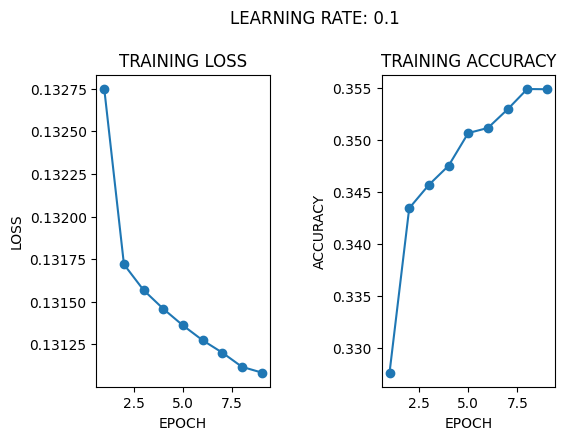

PLOTTING FOR LEARNING RATE: 0.01


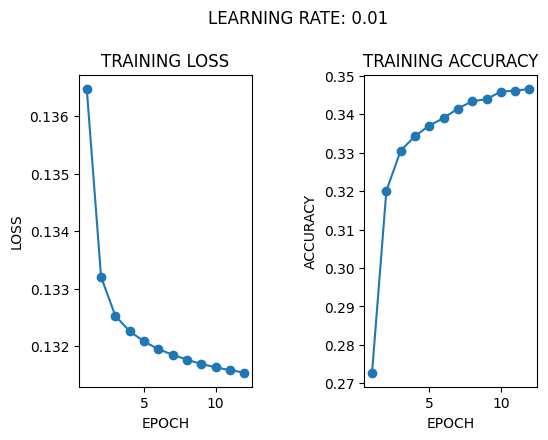

PLOTTING FOR LEARNING RATE: 0.001


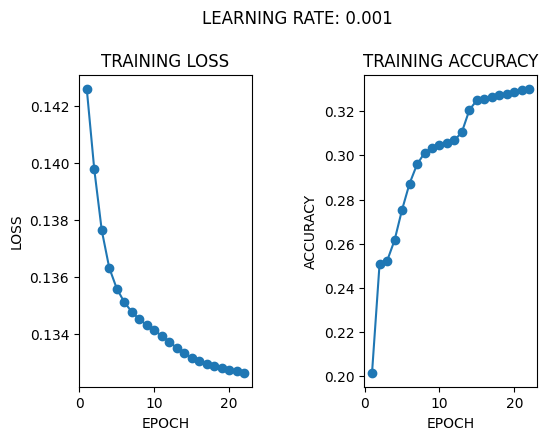

PLOTTING FOR LEARNING RATE: 0.0001


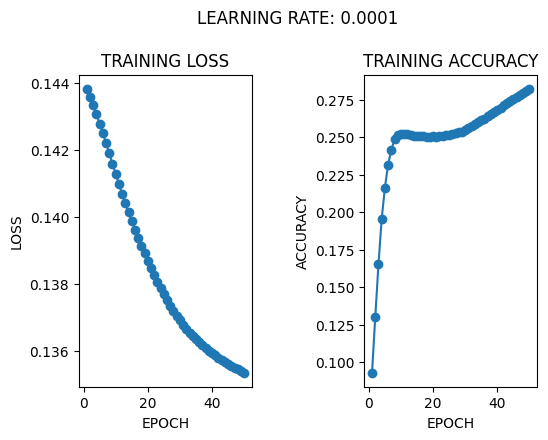

PLOTTING FOR LEARNING RATE: 1e-05


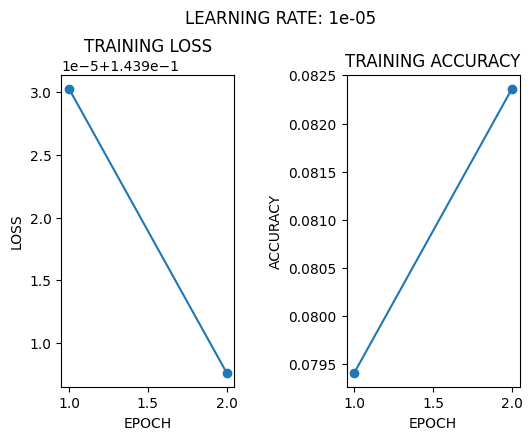

In [11]:
for i, lr in enumerate([0.1, 0.01, 0.001, 0.0001, 0.00001]):
    losses, accuracies = results[i]

    print("===================================================")
    print(f"PLOTTING FOR LEARNING RATE: {lr}")
    
    fig, axis = plt.subplots(1,2)
    fig.tight_layout(pad=5.0)
    fig.suptitle(f"LEARNING RATE: {lr}")
    axis[0].set(xlabel = "EPOCH", ylabel = "LOSS", title="TRAINING LOSS")
    axis[0].plot(list(range(1,len(losses)+1)), losses, marker="o")

    axis[1].set(xlabel = "EPOCH", ylabel = "ACCURACY", title="TRAINING ACCURACY")
    axis[1].plot(list(range(1,len(accuracies)+1)), accuracies, marker="o")

    plt.show()

In [12]:
def eval(model, dataloader):
    model.eval()
    corrects = 0

    for i, data in enumerate(dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward + backward + optimize
        outputs = model(inputs)

        _, preds = torch.max(outputs.data, 1)
        _, correct_labels = torch.max(labels.data ,1)

        corrects += float(torch.sum(preds == correct_labels))

    print("Precision: {:.3f}".format(corrects/len(dataset_test)))
    return corrects/len(dataset_test)

In [15]:
base_path = "nn_weights/"
precisions = dict()
for d in os.listdir(base_path):
    if os.path.isdir(os.path.join(base_path, d)):
        files = os.listdir(os.path.join(base_path, d))

        weights = files[-1]
        state_dict = torch.load(os.path.join(base_path, d, weights))
        model.load_state_dict(state_dict)

        d = d.split("[")[-1][:-1]
        precisions[d] = eval(model, dataloader_test)

Precision: 0.284
Precision: 0.330
Precision: 0.345
Precision: 0.351
Precision: 0.086


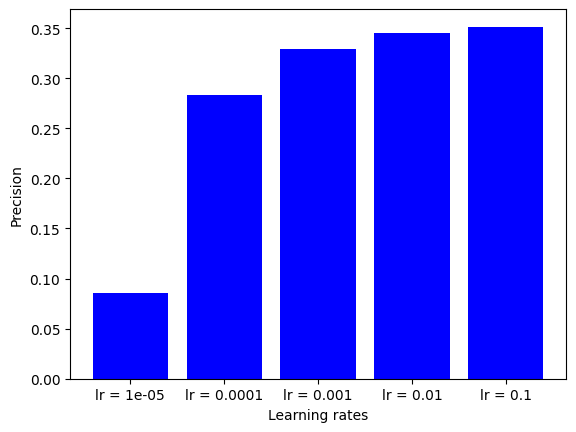

: 

In [16]:
sorted_precisions = dict(sorted(precisions.items(), key=lambda x:x[1]))

labels = list(sorted_precisions.keys())
values = list(sorted_precisions.values())

# Create a bar plot
plt.bar(labels, values, color='blue')

# Add labels and title
plt.xlabel('Learning rates')
plt.ylabel('Precision')

# Show the plot
plt.show()

Metrics with the best weights so far

In [40]:
model = StudentScoreClassifier().to(device)
model.eval()

not_trained_state_dict = torch.load("nn_weights/no_features_engineering[lr = 0.1]/epoch 8.pt") # Done to reset the network
model.load_state_dict(not_trained_state_dict)

y_pred = torch.empty(0).to(device)

for i, data in enumerate(dataloader_test):
    
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    _, preds = torch.max(outputs.data, 1)

    y_pred = torch.cat((y_pred, preds))

In [41]:
y_true = []

for i in dataset_test:
    y_true.append(torch.argmax(i[1]).item())

y_pred = y_pred.tolist()
report = metrics.classification_report(y_true, y_pred)


C:\Users\stefa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stefa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stefa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\metrics\_classification.py:1469: Unde

In [43]:
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       265
           1       0.00      0.00      0.00       159
           2       0.00      0.00      0.00       346
           3       0.00      0.00      0.00       583
           4       0.00      0.00      0.00      1443
           5       0.00      0.00      0.00      2317
           6       0.00      0.00      0.00      4815
           7       0.19      0.30      0.23      6274
           8       0.26      0.38      0.31      8340
           9       0.25      0.33      0.28      8136

    accuracy                           0.23     32678
   macro avg       0.07      0.10      0.08     32678
weighted avg       0.16      0.23      0.19     32678

